## <font color='cornflowerblue'> Data

In [1]:
import ta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [2]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

In [3]:
rsi_indicator = ta.momentum.RSIIndicator(close=data.Close, window=15)

data['rsi'] = rsi_indicator.rsi()
data['buy_signal'] = data['rsi'] < 20
data['sell_signal'] = data['rsi'] > 80

data = data.dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
18,18,1609776000,0,2021-01-04 16:00:00,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False


## <font color='cornflowerblue'> Classes and Functions

In [4]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # Add short positions equity (margin_account + margin_requirement - cost to cover)
    for pos in short_ops:
        cover_cost = current_price * pos.n_shares * (1 + COM)  # include commission
        margin_requirement = pos.price * pos.n_shares * INITIAL_MARGIN
        proceeds = pos.price * pos.n_shares - cover_cost
        val +=  proceeds + margin_requirement - cover_cost

    return val

## <font color='cornflowerblue'> Parameters

In [6]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 0.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = (1 + BORROW_RATE) ** (1 / bars_per_year) - 1

# DOF
STOP_LOSS: float = 0.1
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [7]:
capital: float = 1_000_000
margin_account: float = 0.0

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares * (1 + COM)
        capital -= row.Close * position.n_shares * bar_borrow_rate
        equity += position.price * position.n_shares * (1 - COM) - cover_cost + position.price * position.n_shares * INITIAL_MARGIN

        # Required Equity
        required_equity += MAINTENANCE_MARGIN * cover_cost
        
    for position in active_short_positions.copy():
        cover_cost = row.Close * position.n_shares * (1 + COM)
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = required_equity - equity
            print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required: {required_equity:.2f}')

            if capital > deposit:
                capital -= deposit
                equity += deposit
                
            else:
                # We have to close the position
                capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                margin_account -= position.price * N_SHARES * (1 - COM)
                active_short_positions.remove(position)
                #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                #required_equity -= MAINTENANCE_MARGIN * cover_cost
                continue

        else:
            # Stop loss or take profit check
            if row.Close < position.tp or row.Close > position.sl:
                # Add profits / losses to capital
                capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                margin_account -= position.price * N_SHARES * (1 - COM)
                active_short_positions.remove(position)
                #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                #required_equity -= MAINTENANCE_MARGIN * cover_cost
                continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        
        # Do we have enough cash?
        if capital > margin_requirement:
            # Setting up the margin account
            margin_account += row.Close * N_SHARES * (1 - COM)
            # Discount cash
            capital -= margin_requirement

            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
    continue
# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    capital += position.price * N_SHARES * INITIAL_MARGIN - row.Close * N_SHARES * (1 + COM) + position.price * N_SHARES * (1 - COM)
    margin_account -= position.price * N_SHARES * (1 - COM)
    #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
    #required_equity -= MAINTENANCE_MARGIN * cover_cost

active_long_positions = []
active_short_positions = []

In [8]:
capital

1043449.9190749369

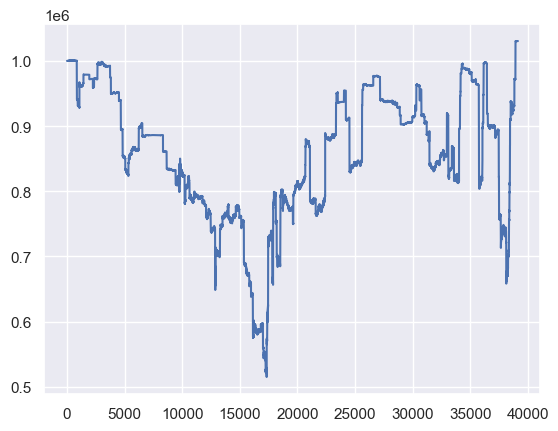

In [9]:
plt.plot(portfolio_value);